# TEST version- Trying to cluster! 
## Heat Map of vascular phenotypes genes (Pascal) intersection 

## PROBLEM: without merge cells => The image needs to be done manually on powerpoint: merge cells and colors
###### Last modification 18/10/2022

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from datetime import datetime

DATE = datetime.now().strftime("%Y-%m-%d")

In [17]:
num_ventile = 5
input_dir = '/NVME/decrypted/scratch/multitrait/UK_BIOBANK_ZERO/gwas/2022_08_03_ventile'+str(num_ventile)+'/'
save_results = '/SSD/home/sofia/retina-phenotypes/complementary/GWAS_postprocessing/common_genes_path_snps/'
phenotypes_type='main'
csv_name = 'intersections_'+phenotypes_type
csv_name_all = 'intersections_all_'+phenotypes_type
csv_genes_name = 'intersections_genes_name_'+phenotypes_type
csv_name_diagonal = 'intersections_diagonal_'+phenotypes_type
csv_name_count = 'genes_count_'+phenotypes_type
p_value_min = 5.7  # -math.log10(0.05/len(x))

if phenotypes_type=='complementary':
    filenames= ["ratio_AV_DF","AVScore_all", "tau1_all", "tau1_artery", "tau1_vein", "tau2_all", "tau2_artery", "tau2_vein", "tau4_all", "tau4_artery", "tau4_vein", "D_std", "D_A_std", "D_V_std", "D_median_CVMe", "D_CVMe", "D_CVMe_A", "D_CVMe_V", "N_median_main_arteries", "N_median_main_veins", "arcLength_artery", "arcLength_vein", "bifurcations", "VD_orig_all", "VD_orig_artery", "VD_orig_vein", "ratio_VD", "slope", "slope_artery", "slope_vein", "mean_angle_taa", "mean_angle_tva", "medianCenter1_artery", "medianCenter1_vein", "medianCenter2_artery", "medianCenter2_vein", "eq_CRAE", "eq_CRVE", "median_CRAE", "median_CRVE", "ratio_CRAE_CRVE", "ratio_median_CRAE_CRVE", "medianDiameter_all", "medianDiameter_artery", "medianDiameter_vein", "ratio_AV_medianDiameter"]
    size_a=35
    size_b=35
elif phenotypes_type=='main':
    filenames= ["ratio_AV_DF", "tau1_artery" , "tau1_vein" , "D_A_std" , "D_V_std" , "bifurcations" , "VD_orig_artery" , "VD_orig_vein" , "ratio_VD" , "mean_angle_taa" , "mean_angle_tva" , "eq_CRAE" , "eq_CRVE" , "ratio_CRAE_CRVE" , "medianDiameter_artery" , "medianDiameter_vein" , "ratio_AV_medianDiameter"]
    size_a=12
    size_b=12

### - Already included in 'main_gene_analysis.py' and 'function_genes.py'

In [18]:
def difference_diagonal(save_results):
    df_v2=pd.read_csv(save_results+ 'intersections_diagonal_main_v2.csv')
    df_v5=pd.read_csv(save_results+ 'intersections_diagonal_main_v5.csv')
    if len(df_v2) != len(df_v5):   
        print('Error, different lens in intersections_diagonal_main')
    #df_v5= df_v5[['file_col', 'gen_y']]
    #df_v5.set_index('file_col').plot.bar(rot=90, title='ventile5', figsize=(10,5), fontsize=12)
    df_v5.rename(columns = {'gen_y':'V5_gen_y'}, inplace = True)
    df_v2.rename(columns = {'gen_y':'V2_gen_y'}, inplace = True)
    df_aux= df_v2.merge(df_v5, on='file_col', how='inner')
    df_aux['dif_v5_minus_v2']=df_aux['V5_gen_y']-df_aux['V2_gen_y']
    #df_v2= df_v2[['file_col', 'gen_y']]
    df_aux.set_index('file_col').plot.bar(rot=90, title='v5 -v2', figsize=(10,5), fontsize=12)
    #plt.savefig(save_results+'/'+str(DATE)+'_difference_ventiles_genes_intersection.pdf', edgecolor='none')
    sys.exit()

In [26]:
def plot():
    df_pintar = pd.read_csv(save_results + csv_name + '_v'+str(num_ventile) + '.csv')
    #df_pintar= df_pintar.drop(columns=['Unnamed: 0'])
    df_pintar= df_pintar.set_index('Unnamed: 0')
    #df_pintar.index= df_pintar.columns
    df_pintar=df_pintar.astype(int)
    #print(df_pintar.columns)

    plt.subplots(figsize=(size_a,size_b))
    sns.heatmap(df_pintar, annot=True, cmap="YlGnBu")
    #plt.savefig(save_results+'/'+str(DATE)+'_ventile'+str(num_ventile)+'_Heatmap_genes_intersection.pdf', edgecolor='none')



def compute_intersections_csv():
    l_aux = []

    for file in filenames:
        #print('file', file)
        # Read csvs
        df = pd.read_csv(input_dir+file+'__gene_scores', delimiter='\t', names =['gen', 'p']) #, index_col=None, header=0)
        df['file_col']=file
        l_aux.append(df)

    # Concat all the csvs
    df_concat = pd.concat(l_aux)

    # From p to -log10(p)
    df_concat['-log10(p)'] = -np.log10(df_concat['p'])
    y = df_concat[df_concat['-log10(p)'] >= p_value_min]
    df_significant = y.sort_values('-log10(p)', ascending=False)
    #print(df_significant.head(5))
    df_significant.to_csv(save_results + csv_name_all + '.csv')
    df_count=df_significant['gen'].value_counts().to_frame()
    df_count['ratio_N_pheno']=df_significant['gen'].value_counts().to_frame()/len(filenames)
    df_count.to_csv(save_results + csv_name_count + '.csv')

    ## Save the number of significant genes per phenotype
    df_guardar = pd.DataFrame(df_significant.groupby(by=['file_col'])['gen'].apply(list))
    df_guardar2 = pd.DataFrame(df_significant.groupby(by=['file_col'])['gen'].count())
    df_guardar_final=df_guardar.merge(df_guardar2, how='inner', on='file_col')
    df_guardar_final.to_csv(save_results + csv_name_diagonal + '_v'+str(num_ventile) +'.csv')
    df_save_shapes=pd.DataFrame([])
    df_save_intersections=pd.DataFrame([])


    i=0
    for file in filenames:
        i=i+1
        genes=df_significant[df_significant['file_col']==file]['gen']#.to_list()
        genes=genes.to_list()
        l_aux2 = []
        l_aux3 = []

        for j in range(len(filenames)):#-i):#-file: #Error
            other_file=filenames[j]
            df_intersection=df_significant[(df_significant['file_col']==other_file)&(df_significant['gen'].isin(genes))]
            # To save the intersection len
            save_shapes=df_intersection.shape[0]
            l_aux3.append(save_shapes)

            # To save the names of the genes in the intersection
            l_aux2.append(df_intersection['gen'].to_list())# {'index1': value1, 'index2':value2,...}, ignore_index=True)#.to_list())
            #print('antes', df_intersection['gen'].to_list(), 'despues')
            #print(df_intersection['gen'].values())

        # To save the intersection len
        df = pd.DataFrame({file:l_aux3})
        df_save_shapes = pd.concat([df_save_shapes, df], axis=1)

        # To save the names of the genes in the intersection
        df2 = pd.DataFrame({file:l_aux2})
        df_save_intersections = pd.concat([df_save_intersections, df2], axis=1)
        #print(df_save_intersections[1])

    # To save the intersection len  
    df_save_shapes = df_save_shapes.set_axis(df_save_shapes.columns, axis='index')
    df_save_shapes.to_csv(save_results + csv_name + '_v'+str(num_ventile) +'.csv')

    # To save the names of the genes in the intersection
    df_save_intersections = df_save_intersections.set_axis(df_save_intersections.columns, axis='index')
    df_save_intersections.to_csv(save_results + csv_genes_name + '_v'+str(num_ventile) + '.csv')



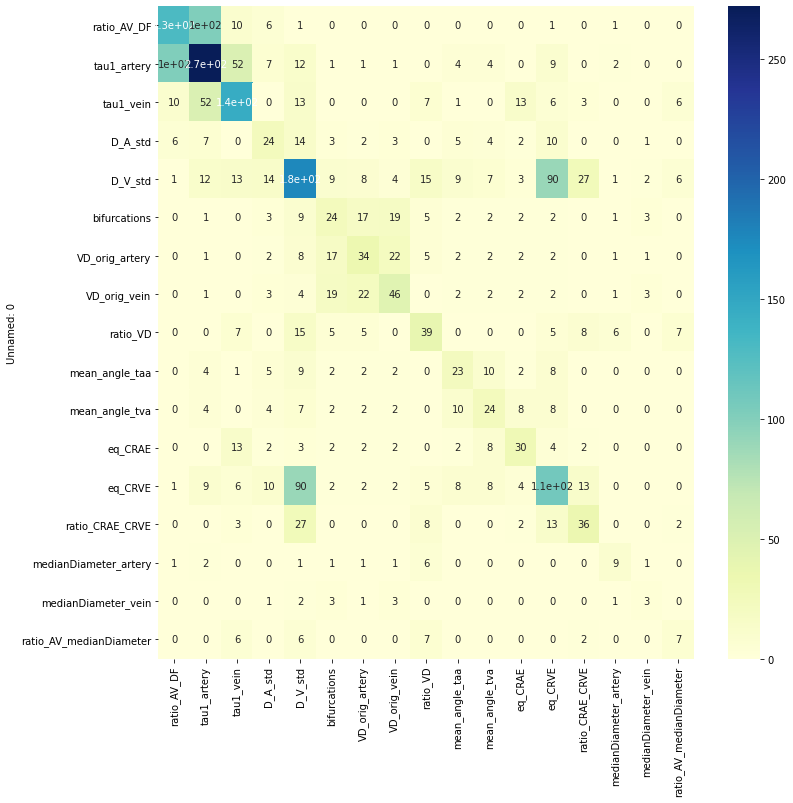

In [27]:
compute_intersections_csv()
plot()

## - Create half half (half with numbers and half with the names)

In [29]:
df_numbers = pd.read_csv(save_results + csv_name + '_v'+str(num_ventile) +'.csv')
df_numbers= df_numbers.set_index('Unnamed: 0')

df_names = pd.read_csv(save_results + csv_genes_name + '_v'+str(num_ventile) + '.csv')
df_names= df_names.set_index('Unnamed: 0')

In [30]:
import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot as plt
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
### You need to: 
## - delete the nans, 
## - diagonal to 0, and
## - abs(linkage)

##### IT IS NOT SIMETRIC!
np_upper = np.triu(df_numbers)
#df = df1.fillna(df2)
df_upper=pd.DataFrame(np_upper)

np_lower = np.tril(df_names, k=-1)
df_lower=pd.DataFrame(np_lower)

In [31]:
#np_upper.shape

i_upper = np.triu_indices(16)
np_final = np_lower
np_final[i_upper] = np_upper[i_upper]
df_c_m = pd.DataFrame(np_lower)
df_c_m.columns = df_names.columns
df_c_m.index = df_names.columns
#df_c_m.to_csv('/SSD/home/sofia/retina-phenotypes/complementary/GWAS_postprocessing/common_genes_path_snps/2022_08_12_both.csv')

# - Cluster with distances:

In [33]:
df_aux = df_numbers
l=[]
for i in range(len(df_aux)):
    lista=df_aux.iloc[i]/df_aux.iloc[i][i]
    l.append(lista)
df_ratios= pd.DataFrame(l)

In [34]:
df_ratios

,ratio_AV_DF,tau1_artery,tau1_vein,D_A_std,D_V_std,bifurcations,VD_orig_artery,VD_orig_vein,ratio_VD,mean_angle_taa,mean_angle_tva,eq_CRAE,eq_CRVE,ratio_CRAE_CRVE,medianDiameter_artery,medianDiameter_vein,ratio_AV_medianDiameter
ratio_AV_DF,1.000000,0.776923,0.076923,0.046154,0.007692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007692,0.000000,0.007692,0.000000,0.000000
tau1_artery,0.371324,1.000000,0.191176,0.025735,0.044118,0.003676,0.003676,0.003676,0.000000,0.014706,0.014706,0.000000,0.033088,0.000000,0.007353,0.000000,0.000000
tau1_vein,0.068966,0.358621,1.000000,0.000000,0.089655,0.000000,0.000000,0.000000,0.048276,0.006897,0.000000,0.089655,0.041379,0.020690,0.000000,0.000000,0.041379
D_A_std,0.250000,0.291667,0.000000,1.000000,0.583333,0.125000,0.083333,0.125000,0.000000,0.208333,0.166667,0.083333,0.416667,0.000000,0.000000,0.041667,0.000000
D_V_std,0.005682,0.068182,0.073864,0.079545,1.000000,0.051136,0.045455,0.022727,0.085227,0.051136,0.039773,0.017045,0.511364,0.153409,0.005682,0.011364,0.034091
bifurcations,0.000000,0.041667,0.000000,0.125000,0.375000,1.000000,0.708333,0.791667,0.208333,0.083333,0.083333,0.083333,0.083333,0.000000,0.041667,0.125000,0.000000
VD_orig_artery,0.000000,0.029412,0.000000,0.058824,0.235294,0.500000,1.000000,0.647059,0.147059,0.058824,0.058824,0.058824,0.058824,0.000000,0.029412,0.029412,0.000000
VD_orig_vein,0.000000,0.021739,0.000000,0.065217,0.086957,0.413043,0.478261,1.000000,0.000000,0.043478,0.043478,0.043478,0.043478,0.000000,0.021739,0.065217,0.000000
ratio_VD,0.000000,0.000000,0.179487,0.000000,0.384615,0.128205,0.128205,0.000000,1.000000,0.000000,0.000000,0.000000,0.128205,0.205128,0.153846,0.000000,0.179487
mean_angle_taa,0.000000,0.173913,0.043478,0.217391,0.391304,0.086957,0.086957,0.086957,0.000000,1.000000,0.434783,0.086957,0.347826,0.000000,0.000000,0.000000,0.000000


In [35]:
import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot as plt
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
### You need to: 
## - delete the nans, 
## - diagonal to 0, and
## - abs(linkage)

##### IT IS NOT SIMETRIC!
np_upper = np.triu(df_ratios)
df_upper=pd.DataFrame(np_upper)
df_upper = df_upper.T+ df_upper ##diagonal values=2

np_lower = np.tril(df_ratios)
df_lower=pd.DataFrame(np_lower)
df_lower = df_lower.T+ df_lower

In [36]:
#set index and column names back (since the cluster is not done yet it is okay)

len(df_upper)
df_upper.columns = df_ratios.columns
df_upper.index= df_ratios.index

df_lower.columns = df_ratios.columns
df_lower.index= df_ratios.index

df_upper_aux=df_upper.copy()
df_lower_aux=df_lower.copy()

In [37]:
#set diagonal values = 1

df_upper.values[[np.arange(df_upper.shape[0])]*2] = 1
df_lower.values[[np.arange(df_lower.shape[0])]*2] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.


In [38]:
# Check the values are correct: 
Check_correct=False
if Check_correct=='True':
    df_ratios - df_upper #Correct Outcome: First triang half and diag = 0
    df_ratios - df_lower #Correct Outcome: Second triang half and diag = 0
    df_upper_aux - df_upper #Correct Outcome: All 0 except diag = 1
    df_lower_aux - df_lower #Correct Outcome: All 0 except diag = 1

In [39]:
########## df_upper

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


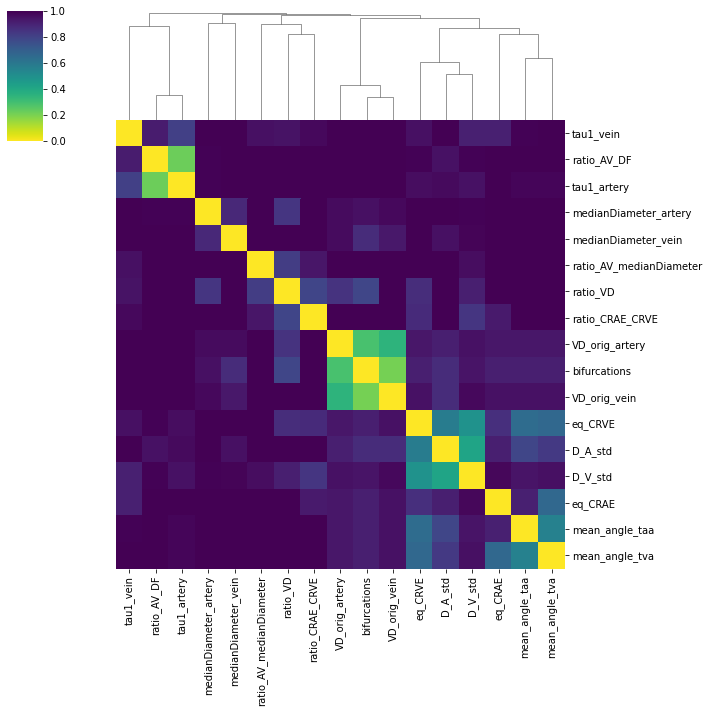

In [40]:
df_upper_ = 1 - abs(df_upper) 
## diagonal same value:
df_upper_.values[[np.arange(df_upper_.shape[0])]*2] = 0

linkage = hc.linkage(sp.distance.squareform(df_upper_), method='average')
#lik_abs= abs(linkage)
h = sns.clustermap(df_upper_, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('viridis_r'), figsize=(10,10), vmin=0, vmax=1)
h.ax_row_dendrogram.set_visible(False)
#h.ax_heatmap.xaxis.tick_top()
h.ax_heatmap.tick_params(axis='x', rotation=90)
#plt.savefig('/SSD/home/sofia/retina-phenotypes/complementary/GWAS_postprocessing/ldsr_correlation/03_08_2022_gcorrimagen.jpg')

In [41]:
########## df_lower

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


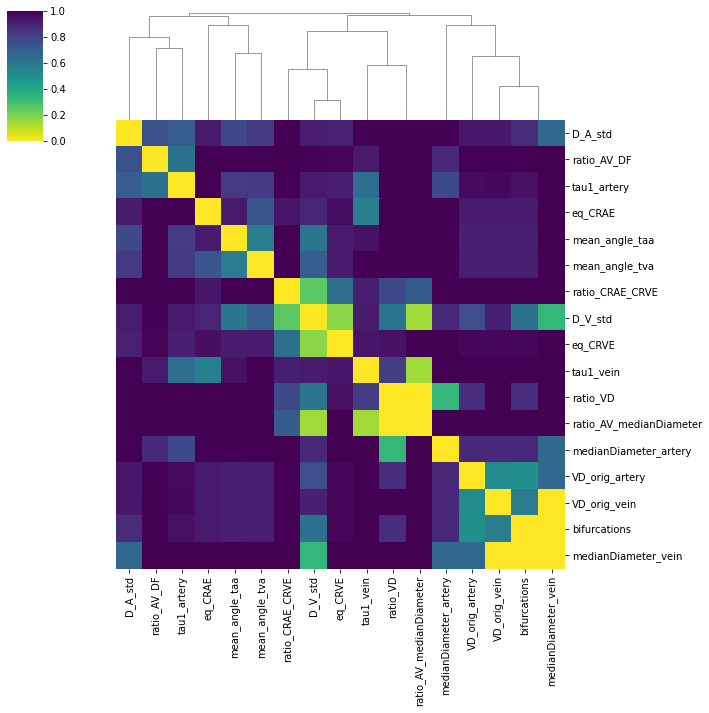

In [42]:
df_lower_ = 1 - abs(df_lower) 
## diagonal same value:
df_upper_.values[[np.arange(df_upper_.shape[0])]*2] = 0

linkage = hc.linkage(sp.distance.squareform(df_lower_), method='average')
#lik_abs= abs(linkage)
h = sns.clustermap(df_lower_, row_linkage=linkage, col_linkage=linkage, cmap=cm.get_cmap('viridis_r'), figsize=(10,10), vmin=0, vmax=1)
h.ax_row_dendrogram.set_visible(False)
#h.ax_heatmap.xaxis.tick_top()
h.ax_heatmap.tick_params(axis='x', rotation=90)
#plt.savefig('/SSD/home/sofia/retina-phenotypes/complementary/GWAS_postprocessing/ldsr_correlation/03_08_2022_gcorrimagen.jpg')

### - Count number of zeros per row (as another potential criterium)

In [44]:
df_zeros = (df_numbers == 0).astype(int).sum(axis=1)
df_zeros=pd.DataFrame(df_zeros)
(df_numbers == 0).astype(int).sum(axis=1)

Unnamed: 0
ratio_AV_DF                10
tau1_artery                 5
tau1_vein                   7
D_A_std                     5
D_V_std                     0
bifurcations                4
VD_orig_artery              4
VD_orig_vein                5
ratio_VD                    8
mean_angle_taa              6
mean_angle_tva              7
eq_CRAE                     6
eq_CRVE                     3
ratio_CRAE_CRVE            10
medianDiameter_artery       8
medianDiameter_vein        10
ratio_AV_medianDiameter    12
dtype: int64

In [46]:
df_zeros = df_zeros.sort_values(by=0, ascending=True, na_position='first')
df_zeros

,0
Unnamed: 0,
D_V_std,0
eq_CRVE,3
bifurcations,4
VD_orig_artery,4
tau1_artery,5
D_A_std,5
VD_orig_vein,5
eq_CRAE,6
mean_angle_taa,6
